# Imports and preinstallation

## Install libs

In [0]:
!pip install eli5

    100% |████████████████████████████████| 102kB 4.7MB/s 


In [0]:
!pip install plotly --upgrade

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (3.6.1)


Fix for 'title' has invalid value inside 'layout'

In [0]:
!pip install clint

In [0]:
!pip install utils

## Imports

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.measure import compare_ssim as ssim
import skimage
import tarfile
import sklearn.utils
import sklearn as skl
import IPython.display as ipd
import requests
import sys
import zipfile
import pandas as pd
import ast
import librosa
import librosa.display
from PIL import Image
import numpy as np
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
from time import time
import IPython
import xgboost as xgb
import scipy as sc
from keras import models, layers, optimizers, utils, losses, callbacks, regularizers
import tensorflow
import csv
import google.colab as gc
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
import concurrent
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


## Help functions

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_data_file = '/content/drive/My Drive/contest_train.csv'
test_data_file = '/content/drive/My Drive/contest_test.csv'
test_out_data_file = '/content/drive/My Drive/contest_test_out.csv'

augmented_train_data_file = '/content/drive/My Drive/contest_aug_train.csv'
augmented_test_data_file = '/content/drive/My Drive/contest_aug_test.csv'

In [0]:
np.random.seed(42)
tensorflow.set_random_seed(42)

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

#IPython.get_ipython().events.unregister('pre_run_cell', configure_plotly_browser_state)
init_notebook_mode(connected=True)

In [0]:
def download(url, filename):
    with open(filename, 'wb') as f:
        response = requests.get(url, stream=True)
        total = response.headers.get('content-length')

        if total is None:
            f.write(response.content)
        else:
            sys.stdout.write('Downloading {} of size {} from {}\n'.format(
                filename, total, url))
            downloaded = 0
            total = int(total)
            for data in response.iter_content(chunk_size=max(int(total/1000), 1024*1024)):
                downloaded += len(data)
                f.write(data)
                done = int(50*downloaded/total)
                sys.stdout.write('\r[{}{}]'.format('█' * done, '.' * (50-done)))
                sys.stdout.flush()
    sys.stdout.write('\nDone\n')

In [0]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [0]:
def plot_history(history, title=''):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy ' + title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Extracting features from mp3

## Download

In [0]:
with zipfile.ZipFile('drive/My Drive/Colab Notebooks/dataset/train.zip', 'r') as zip_ref:
    zip_ref.extractall('train/')

In [0]:
with zipfile.ZipFile('drive/My Drive/Colab Notebooks/dataset/test.zip', 'r') as zip_ref:
    zip_ref.extractall('test/')

In [0]:
train_tracks_data = pd.read_csv('train/train.csv')
train_tracks_data.head(10)

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
5,6,children_playing
6,10,street_music
7,11,drilling
8,12,gun_shot
9,15,dog_bark


In [0]:
test_tracks_data = pd.read_csv('test/test.csv')
test_tracks_data.head(10)

,ID
0,5
1,7
2,8
3,9
4,13
5,14
6,16
7,21
8,23
9,25


In [0]:
train_tracks_data.loc[train_tracks_data['ID'] == 11]['Class'].values[0]

'drilling'

## Processing mp3 old

In [0]:
def extract_info(audio_fpath, audio_fname):
  y, sr = librosa.load(audio_fpath, mono=True, duration=30)
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = librosa.feature.rmse(y=y)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y)
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=128)
  to_append = f'{audio_fname} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
  for e in mfcc:
      to_append += f' {np.mean(e)}'
  return to_append

In [0]:
data_file = open('my_train.csv', 'w', newline='')
header = 'id chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 128 + 1):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

with data_file:
  writer = csv.writer(data_file)
  writer.writerow(header)

ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in os.walk('train'):
  for file in sorted(files):
    if file.lower().endswith('.wav'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        info = extract_info(fpath, fname)
        track_id = int(fname)
        genre = train_tracks_data.loc[train_tracks_data['ID'] == track_id]['Class'].values[0]
        info += f' {genre}'
        data_file = open('my_train.csv', 'a', newline='')
        with data_file:
            writer = csv.writer(data_file)
            writer.writerow(info.split())
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      print('OK', file, 'with path:', fpath)
      #ci += 1
      #if ci >= count:
        #reak
    else:
      continue
  #if ci >= count:
    #break

print('Generating data finished! Generated {}/{} successfully'.format(ok_cnt, ok_cnt + fail_cnt))

In [0]:
data_file = open('my_test.csv', 'w', newline='')
header = 'id chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 128 + 1):
    header += f' mfcc{i}'
header = header.split()

with data_file:
  writer = csv.writer(data_file)
  writer.writerow(header)

ok_cnt = 0
fail_cnt = 0
#count = 4
#ci = 0
for subdir, _, files in os.walk('test2'):
  for file in sorted(files):
    if file.lower().endswith('.wav'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        info = extract_info(fpath, fname)
        data_file = open('my_test.csv', 'a', newline='')
        with data_file:
            writer = csv.writer(data_file)
            writer.writerow(info.split())
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      print('OK', file, 'with path:', fpath)
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break

print('Generating data finished! Generated {}/{} successfully'.format(ok_cnt, ok_cnt + fail_cnt))


https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8

In [0]:
from google.colab import files
#files.download('my_train.csv')
files.download('my_test.csv')

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# '/content/drive/My Drive/Colab Notebooks/my_data.csv'

Mounted at /content/drive


## Converting mp3

In [0]:
def extract_info(audio_fpath, audio_fname):
  y, sr = librosa.load(audio_fpath, sr=12000, mono=True)
  stft = np.abs(librosa.stft(y)) # np.abs(D[f, t]) is the magnitude of frequency bin f at frame t
  onset_env = librosa.onset.onset_strength(S=stft, sr=sr)
  tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
  mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10).T, axis=0)  # 10 values
  rmse = np.mean(librosa.feature.rmse(y=y))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
  mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
  spec_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=4).T, axis=0)
  tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0) # tonal centroid features
  to_append = f'{audio_fname}'
  for v in mfccs:
    to_append += f',{v}'
  to_append += f',{tempo},{rmse},{zcr},{rolloff},{spec_cent},{spec_bw}'
  for v in spec_contrast:
    to_append += f',{v}'
  for v in chroma_stft:
    to_append += f',{v}'
  for v in mel:
    to_append += f',{v}'
  for v in tonnetz:
    to_append += f',{v}'
  return to_append

### Train

**Warning: overwriting**

In [0]:
data_file = open(train_data_file, 'w', newline='')
header = 'filename'
for i in range(10):
  header += f',mfcc{i}'
header += ',tempo,rmse,zcr,rolloff,spec_cent,spec_bw'
for i in range(5):
  header += f',spec_contrast{i}'
for i in range(12):
  header += f',chroma_stft{i}'
for i in range(128):
  header += f',mel{i}'
for i in range(6):
  header += f',tonnetz{i}'
header += ',label\n'

with data_file:
  data_file.write(header)

In [0]:
data = pd.read_csv(train_data_file)
processed = np.unique(data['filename'])
processed.shape

(235,)

In [0]:
ok_cnt = 0
fail_cnt = 0

#count = 4
#ci = 0
for subdir, _, files in sorted(os.walk('train')):
  for file in sorted(files):
    if file.lower().endswith('.wav'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        track_id = int(fname)
        if track_id in processed:
          ok_cnt += 1
          if ok_cnt % 100 == 0:
            print(f'OK {ok_cnt}')
          continue
        genre = train_tracks_data.loc[train_tracks_data['ID'] == track_id]['Class'].values[0]
        info = extract_info(fpath, fname) + f',{genre}\n'
        with open(train_data_file, 'a', newline='') as data_file:
          data_file.write(info)
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      if ok_cnt % 100 == 0:
        print(f'OK {ok_cnt}')
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break
print('Generated {}/{}'.format(ok_cnt, ok_cnt + fail_cnt))

OK 100
OK 200
OK 300


/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1476: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1489: RuntimeWarning:

invalid value encountered in less



Fail 1488.wav message Audio buffer is not finite everywhere with path: train/Train/1488.wav


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 400


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 500


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 600


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 800


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 900


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1000


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1100
OK 1200
OK 1300


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1400


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1500
OK 1600


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1800


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1900


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2000


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2100


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2200


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2300


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2400


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2500
OK 2600


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2800
OK 2900


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3000


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3100
OK 3200


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3300
OK 3400
OK 3500


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3600
OK 3700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3800


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3900
OK 4000


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4100


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4200


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4300


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4400


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4500
OK 4600
OK 4700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4800


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 4900
OK 5000


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5100


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5200


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 5300
OK 5400


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



Generated 5434/5435


### Test

**Warning: overwriting**

In [0]:
data_file = open(test_data_file, 'w', newline='')
header = 'filename'
for i in range(10):
  header += f',mfcc{i}'
header += ',tempo,rmse,zcr,rolloff,spec_cent,spec_bw'
for i in range(5):
  header += f',spec_contrast{i}'
for i in range(12):
  header += f',chroma_stft{i}'
for i in range(128):
  header += f',mel{i}'
for i in range(6):
  header += f',tonnetz{i}'
header += '\n'

with data_file:
  data_file.write(header)

In [0]:
data = pd.read_csv(test_data_file)
processed = np.unique(data['filename'])
processed.shape

(0,)

In [0]:
ok_cnt = 0
fail_cnt = 0

#count = 4
#ci = 0
for subdir, _, files in sorted(os.walk('test')):
  for file in sorted(files):
    if file.lower().endswith('.wav'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      try:
        track_id = int(fname)
        if track_id in processed:
          ok_cnt += 1
          if ok_cnt % 100 == 0:
            print(f'OK {ok_cnt}')
          continue
        info = extract_info(fpath, fname) + '\n'
        with open(test_data_file, 'a', newline='') as data_file:
          data_file.write(info)
      except Exception as e:
        print('Fail', file, 'message', e, 'with path:', fpath)
        fail_cnt += 1
        continue
      ok_cnt += 1
      if ok_cnt % 100 == 0:
        print(f'OK {ok_cnt}')
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break
print('Generated {}/{}'.format(ok_cnt, ok_cnt + fail_cnt))

OK 100


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 200
OK 300


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 400
OK 500


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 600


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 700
OK 800
OK 900
OK 1000
OK 1100
OK 1200
OK 1300
OK 1400


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1500
OK 1600
OK 1700


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 1800
OK 1900


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2000


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2100


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2200


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.

/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2300
OK 2400


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2500


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2600
OK 2700
OK 2800


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 2900


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3000
OK 3100


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



OK 3200


/usr/local/lib/python3.6/dist-packages/librosa/core/pitch.py:145: UserWarning:

Trying to estimate tuning from empty frequency set.



Generated 3297/3297


## Converting mp3 + data augmentation (only train)

### Data augmentation

#### Street music

In [0]:
y, sr = librosa.load('train/Train/1.wav', sr=12000, mono=True)
ipd.Audio(y, rate=sr)

In [0]:
# white noise 
wn = np.random.randn(len(y))
y_wn = y + 0.01 * wn # 0.005 0.01
ipd.Audio(y_wn, rate=sr)

In [0]:
# roll
y_roll = np.roll(y, len(y) * 50 // 100) # 10-50
ipd.Audio(y_roll, rate=sr)

In [0]:
# stretching
y_stretch = librosa.effects.time_stretch(y, 0.8)
ipd.Audio(y_stretch, rate=sr)

In [0]:
# stretching
y_stretch = librosa.effects.time_stretch(y, 1.2)
ipd.Audio(y_stretch, rate=sr)

#### Dog

In [0]:
y, sr = librosa.load('train/Train/5927.wav', sr=12000, mono=True)
ipd.Audio(y, rate=sr)

In [0]:
# white noise 
wn = np.random.randn(len(y))
y_wn = y + 0.01 * wn # 0.005 0.01
ipd.Audio(y_wn, rate=sr)

In [0]:
# roll
y_roll = np.roll(y, len(y) * 50 // 100) # 10-50
ipd.Audio(y_roll, rate=sr)

In [0]:
# stretching
y_stretch = librosa.effects.time_stretch(y, 0.8)
ipd.Audio(y_stretch, rate=sr)

In [0]:
# stretching
y_stretch = librosa.effects.time_stretch(y, 1.2)
ipd.Audio(y_stretch, rate=sr)

### Extract

In [0]:
def augment(y_orig, wn_coef, roll, stretching):
  # white noise 
  wn = np.random.randn(len(y_orig))
  y = y_orig + wn_coef * wn

  # roll
  y = np.roll(y, len(y) * roll // 100)
  
  # stretching
  y = librosa.effects.time_stretch(y, stretching)
  
  return y

In [0]:
def extract_info(audio_fpath, audio_fname):
  try:
    y_orig, sr = librosa.load(audio_fpath, sr=12000, mono=True)
    for wn_coef in [0, 0.005, 0.007, 0.01]:
      for roll in [10, 25, 50, 100]:
        for stretching in [0.8, 1, 1.2]:
          try:
            y = augment(y_orig, wn_coef, roll, stretching)

            stft = np.abs(librosa.stft(y)) # np.abs(D[f, t]) is the magnitude of frequency bin f at frame t
            onset_env = librosa.onset.onset_strength(S=stft, sr=sr)
            tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
            mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10).T, axis=0)  # 10 values
            rmse = np.mean(librosa.feature.rmse(y=y))
            zcr = np.mean(librosa.feature.zero_crossing_rate(y))
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
            spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
            spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
            chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
            spec_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr, n_bands=4).T, axis=0)
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0) # tonal centroid features
          except Exception as e:
            print(f'Fail processing {audio_fname} message {e} with path: {audio_fpath} coef={wn_coef}, roll={roll}, stretching={stretching}')
            continue
          to_append = f'{audio_fname},{wn_coef},{roll},{stretching}'
          for v in mfccs:
            to_append += f',{v}'
          to_append += f',{tempo},{rmse},{zcr},{rolloff},{spec_cent},{spec_bw}'
          for v in spec_contrast:
            to_append += f',{v}'
          for v in chroma_stft:
            to_append += f',{v}'
          for v in tonnetz:
            to_append += f',{v}'
          yield to_append
  except Exception as e:
    print(f'Fail loading {audio_fname} message {e} with path: {audio_fpath}')

### Train

**Warning: overwriting**

In [0]:
data_file = open(augmented_train_data_file, 'w', newline='')
header = 'filename,wn_coef,roll,stretching'
for i in range(10):
  header += f',mfcc{i}'
header += ',tempo,rmse,zcr,rolloff,spec_cent,spec_bw'
for i in range(5):
  header += f',spec_contrast{i}'
for i in range(12):
  header += f',chroma_stft{i}'
for i in range(6):
  header += f',tonnetz{i}'
header += ',label\n'

with data_file:
  data_file.write(header)

In [0]:
data = pd.read_csv(augmented_train_data_file)
processed = np.unique(data['filename'])
processed.shape

(4170,)

In [0]:
# 1182 1488 1516 2458 300 3033

ok_cnt = 0

#count = 4
#ci = 0

for subdir, _, files in sorted(os.walk('train')):
  for file in sorted(files):
    if file.lower().endswith('.wav'):
      fpath = os.path.join(subdir, file)
      fname, _ = os.path.splitext(file) # (filename, extension)
      
      try:
        track_id = int(fname)
        if track_id in processed:
          ok_cnt += 1
          if ok_cnt % 100 == 0:
            print(f'P {ok_cnt}/{len(files)}')
          continue
          
        genre = train_tracks_data.loc[train_tracks_data['ID'] == track_id]['Class'].values[0]
        with open(augmented_train_data_file, 'a', newline='') as data_file:
          for info in extract_info(fpath, fname):
            data_file.write(info + f',{genre}\n')
            
      except Exception as e:
        print('Fail preprocessing', file, 'message', e, 'with path:', fpath)
        continue
        
      ok_cnt += 1
      if ok_cnt % 100 == 0:
        print(f'P {ok_cnt}/{len(files)}')
        
      #ci += 1
      #if ci >= count:
        #break
    else:
      continue
  #if ci >= count:
    #break
print(f'Generated {ok_cnt}')

P 100/5435
P 200/5435
P 300/5435
P 400/5435
P 500/5435
P 600/5435
P 700/5435
P 800/5435
P 900/5435
P 1000/5435
P 1100/5435
P 1200/5435
P 1300/5435
P 1400/5435
P 1500/5435
P 1600/5435
P 1700/5435
P 1800/5435
P 1900/5435
P 2000/5435
P 2100/5435
P 2200/5435
P 2300/5435
P 2400/5435
P 2500/5435
P 2600/5435
P 2700/5435
P 2800/5435
P 2900/5435
P 3000/5435
P 3100/5435
P 3200/5435
P 3300/5435
P 3400/5435
P 3500/5435
P 3600/5435
P 3700/5435
P 3800/5435
P 3900/5435
P 4000/5435
P 4100/5435


KeyboardInterrupt: ignored

# Neural networks using custom

In [0]:
data = pd.read_csv('drive/My Drive/Colab Notebooks/my_train.csv')
data.head()

,id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc120,mfcc121,mfcc122,mfcc123,mfcc124,mfcc125,mfcc126,mfcc127,mfcc128,label
0,0,0.626637,0.107988,1748.212594,1960.840273,3301.239190,0.085689,-75.095719,129.611846,-32.669898,...,-0.010823,-0.136419,-0.507838,-0.497608,0.446230,0.119575,0.192689,-0.421485,-0.463261,siren
1,1,0.370855,0.227435,1976.408248,2124.078096,4178.935039,0.092059,-8.350567,113.704109,-19.147512,...,-0.509415,-0.455217,-0.374902,-0.416135,0.192311,0.110819,-0.018380,0.091284,-0.553987,street_music
2,10,0.372822,0.041683,2565.956441,2097.926883,4446.979853,0.181226,-197.052198,74.212602,-57.119892,...,-0.239431,-0.745296,1.386992,-0.338301,0.274487,-0.044175,-0.833355,0.688234,-0.814394,street_music
3,100,0.594349,0.059180,1859.945453,2308.293774,4117.322695,0.057394,-221.092725,88.853002,-11.445974,...,0.464164,0.253487,0.101312,0.202341,0.368382,-0.030707,0.246560,0.100828,0.098812,air_conditioner
4,1000,0.428347,0.044038,1967.096463,2042.226892,3872.553654,0.109081,-161.832490,117.374678,-36.599020,...,-0.627504,0.447804,0.135789,0.063041,0.643370,0.060547,0.078396,0.038504,-0.045930,street_music


In [0]:
data.shape

(5435, 136)

In [0]:
ids = data['id']

In [0]:
data = data.drop(['id'], axis=1)

In [0]:
data = skl.utils.shuffle(data)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
np.unique(y)

array([0., 1.], dtype=float32)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype=float))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4348, 134), (1087, 134), (4348, 10), (1087, 10))

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_shape=(x_shape,)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model


In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=4000,
                    batch_size=2000,
                    verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Accuracy: {:.2%}'.format(test_acc))

1087/1087 [==============================] - 0s 111us/step
Accuracy: 94.76%


In [0]:
train_data = skl.utils.shuffle(pd.read_csv('drive/My Drive/Colab Notebooks/my_train.csv'))
train_data.head(5)

,id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc120,mfcc121,mfcc122,mfcc123,mfcc124,mfcc125,mfcc126,mfcc127,mfcc128,label
4451,7450,0.534871,0.101216,3272.634577,2470.634380,6103.978504,0.218166,-66.997662,30.684136,-58.948440,...,-0.322247,-0.561236,-0.261820,0.207279,-0.121257,0.281395,0.036579,-0.063533,0.170294,dog_bark
1892,3747,0.524073,0.040036,1701.086041,2107.417821,3260.786641,0.082172,-179.975571,133.172154,-14.217998,...,0.560840,-0.489654,-0.456350,-0.204207,-0.173314,-0.579225,-0.149164,0.223122,0.237571,engine_idling
1494,3202,0.420876,0.010971,1327.781218,1320.303914,2444.889840,0.083891,-368.119642,185.178067,-61.672694,...,-0.934658,0.503215,0.284947,0.187590,-0.002817,0.053148,0.252322,-0.189628,0.508070,street_music
467,1718,0.128580,0.084372,2192.230359,2012.691730,3721.510059,0.132592,-308.966165,66.760204,-18.143969,...,-1.434885,-0.508063,0.210136,-0.146542,0.467775,-0.986208,0.902160,0.270495,-0.736117,street_music
3475,6074,0.471005,0.039622,3908.304263,2961.716776,7641.611018,0.257748,-158.684954,35.081183,-28.659481,...,0.866573,1.111422,0.957662,0.349530,0.158872,-0.139120,-0.623762,-1.405598,-0.173814,drilling


In [0]:
test_data = pd.read_csv('drive/My Drive/Colab Notebooks/my_test (1).csv')
test_data.head(5)

,id,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,...,mfcc119,mfcc120,mfcc121,mfcc122,mfcc123,mfcc124,mfcc125,mfcc126,mfcc127,mfcc128
0,1002,0.433493,0.097756,1843.958649,1886.054465,3452.041626,0.106262,-103.628500,122.333960,-40.967666,...,2.317316,-1.124332,0.582571,0.752188,-0.133792,-1.289419,1.135100,-0.124614,1.100785,0.033196
1,1005,0.495001,0.001438,1390.000377,1565.652969,2558.779325,0.073920,-554.262332,155.114833,-44.627390,...,-0.074382,0.135127,-0.107028,0.063433,-0.005879,-0.018493,-0.387063,-0.045594,0.017506,-0.192079
2,1009,0.449379,0.019236,2396.609839,1718.705722,4038.346872,0.180526,-251.504526,93.581303,-79.182578,...,0.064811,0.860874,-0.657621,-0.686763,0.159988,0.038962,-0.370479,0.190450,0.458239,0.069009
3,1010,0.394489,0.030221,1450.365498,1759.859509,2577.325263,0.070290,-421.708963,120.998197,-3.984168,...,-0.275550,-0.192445,-0.089057,-0.118499,-0.058788,-0.267067,-0.079121,-0.508275,-0.193924,-0.088072
4,1011,0.226957,0.074632,1065.498637,1443.128055,1699.777222,0.047974,-253.167123,157.888761,-14.844550,...,-0.111005,-0.995478,-0.990456,-0.967456,-0.834525,-0.223728,0.206804,0.252968,-0.350632,-0.388041


In [0]:
ids = test_data['id']

In [0]:
train_data = train_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

In [0]:
# Encoding the Labels
genre_list = train_data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

In [0]:
X_data = np.append(np.array(train_data.iloc[:, :-1], dtype=float), np.array(test_data, dtype=float), axis=0)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(X_data)
X_train = X[:len(train_data)]
X_test = X[len(train_data):]

In [0]:
model = get_model(X_train.shape[1], y.shape[1])
history = model.fit(X_train,
                    y,
                    epochs=4000,
                    batch_size=2000,
                    verbose=0)

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = encoder.inverse_transform(np.argmax(y_pred, axis=1))

In [0]:
np.array(ids).shape, y_pred_classes.shape

((3297,), (3297,))

In [0]:
res = pd.DataFrame({'ID': ids, 'Class': y_pred_classes})
res.to_csv('out.csv', index=False)
res.head(10)

,Class,ID
0,car_horn,1002
1,dog_bark,1005
2,children_playing,1009
3,dog_bark,1010
4,siren,1011
5,drilling,1012
6,drilling,1013
7,engine_idling,1016
8,children_playing,1019
9,jackhammer,102


In [0]:
from google.colab import files
#files.download('my_train.csv')
files.download('out.csv')

# Neural networks using custom v2(3)

## Prepare data

In [0]:
# train_data_file augmented_train_data_file
data = skl.utils.shuffle(pd.read_csv(train_data_file), random_state=42)
data.head()

In [0]:
# test_data_file
test_data = pd.read_csv(test_data_file)
test_data.head()

,filename,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,...,mel124,mel125,mel126,mel127,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5
0,1002,-54.163509,78.196477,-24.648497,19.057854,1.085420,21.774836,5.326390,7.400166,0.797973,...,8.096698e-03,4.066376e-02,1.545045e-02,2.309630e-04,-0.008010,0.011489,0.004514,0.048653,0.016759,0.002906
1,1005,-498.542471,109.428995,-44.941161,26.490302,-16.301730,22.205991,-2.689298,13.313584,0.534248,...,1.556226e-07,9.793334e-08,2.664464e-08,3.582307e-09,-0.020592,0.009674,-0.004869,0.082447,0.012947,-0.022081
2,1009,-197.268915,25.441026,-32.460610,27.992681,-8.737591,37.892281,0.816682,22.064938,-5.171717,...,6.079613e-04,3.662756e-04,7.256838e-05,3.900466e-06,-0.014660,0.008643,0.006326,0.003374,0.003270,0.004381
3,1010,-375.567498,110.323011,-35.257349,-29.015163,-3.364236,-2.352215,-12.537630,-11.761990,2.706602,...,3.197441e-04,1.646495e-04,2.757078e-05,2.090493e-06,-0.000280,0.011665,-0.038748,-0.015320,0.009604,0.002949
4,1011,-191.977751,121.961306,-11.721782,19.788359,7.778484,6.874192,-23.130696,4.172194,23.457142,...,2.924045e-04,1.726315e-04,8.078657e-05,6.776322e-05,0.025675,0.014862,-0.009255,-0.171520,0.013155,0.011339


In [0]:
data.shape, test_data.shape

((5434, 169), (3297, 168))

In [0]:
ids = test_data['filename']

In [0]:
data = data.drop(['filename'], axis=1)
test_data = test_data.drop(['filename'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



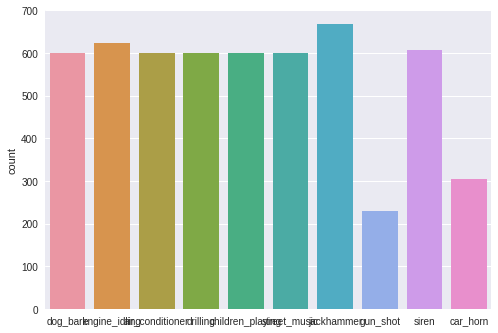

In [0]:
sns.countplot(np.array(genre_list))

In [0]:
X_data = np.append(np.array(data.iloc[:, :-1], dtype=float), np.array(test_data, dtype=float), axis=0)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(X_data)
X_train = X[:len(data)]
X_test = X[len(data):]

In [0]:
#for i in range(X.shape[1]):
  #plt.figure()
  #sns.distplot(X[:,i])
  #plt.title(data.columns[i])

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.05, random_state=42)

In [0]:
X_train.shape, X_val.shape, y_val.shape, y_val.shape, X_test.shape

((5162, 167), (272, 167), (272, 10), (272, 10), (3297, 167))

## Model

Conv > Normalization > Activation > Dropout > Pooling

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  
  model.add(layers.Dense(167, input_shape=(x_shape,), kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(167, kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(42, kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return model


In [0]:
cbs = [callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=50, mode='auto', restore_best_weights=True)]

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 167)               28056     
_________________________________________________________________
batch_normalization_71 (Batc (None, 167)               668       
_________________________________________________________________
activation_71 (Activation)   (None, 167)               0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 167)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 167)               28056     
_________________________________________________________________
batch_normalization_72 (Batc (None, 167)               668       
_________________________________________________________________
activation_72 (Activation)   (None, 167)               0         
__________

## Run

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=cbs)

Train on 5162 samples, validate on 272 samples
Epoch 1/2000
5162/5162 [==============================] - 7s 1ms/step - loss: 2.6866 - acc: 0.1162 - val_loss: 2.2592 - val_acc: 0.2169
Epoch 2/2000
5162/5162 [==============================] - 0s 31us/step - loss: 2.4329 - acc: 0.1670 - val_loss: 2.1435 - val_acc: 0.3566
Epoch 3/2000
5162/5162 [==============================] - 0s 29us/step - loss: 2.3101 - acc: 0.2152 - val_loss: 2.0426 - val_acc: 0.4228
Epoch 4/2000
5162/5162 [==============================] - 0s 28us/step - loss: 2.2110 - acc: 0.2425 - val_loss: 1.9609 - val_acc: 0.4375
Epoch 5/2000
5162/5162 [==============================] - 0s 30us/step - loss: 2.1646 - acc: 0.2743 - val_loss: 1.8846 - val_acc: 0.4265
Epoch 6/2000
5162/5162 [==============================] - 0s 33us/step - loss: 2.0758 - acc: 0.2933 - val_loss: 1.8248 - val_acc: 0.4375
Epoch 7/2000
5162/5162 [==============================] - 0s 29us/step - loss: 2.0026 - acc: 0.3382 - val_loss: 1.7694 - val_acc: 0.

In [0]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

history2 = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=cbs)

Train on 5162 samples, validate on 272 samples
Epoch 1/2000
5162/5162 [==============================] - 8s 2ms/step - loss: 0.3191 - acc: 0.9241 - val_loss: 0.3931 - val_acc: 0.9118
Epoch 2/2000
5162/5162 [==============================] - 0s 29us/step - loss: 0.3234 - acc: 0.9196 - val_loss: 0.3921 - val_acc: 0.9118
Epoch 3/2000
5162/5162 [==============================] - 0s 30us/step - loss: 0.3085 - acc: 0.9250 - val_loss: 0.3916 - val_acc: 0.9118
Epoch 4/2000
5162/5162 [==============================] - 0s 30us/step - loss: 0.3147 - acc: 0.9233 - val_loss: 0.3924 - val_acc: 0.9118
Epoch 5/2000
5162/5162 [==============================] - 0s 32us/step - loss: 0.3237 - acc: 0.9200 - val_loss: 0.3924 - val_acc: 0.9118
Epoch 6/2000
5162/5162 [==============================] - 0s 30us/step - loss: 0.3233 - acc: 0.9235 - val_loss: 0.3927 - val_acc: 0.9118
Epoch 7/2000
5162/5162 [==============================] - 0s 29us/step - loss: 0.2936 - acc: 0.9287 - val_loss: 0.3926 - val_acc: 0.

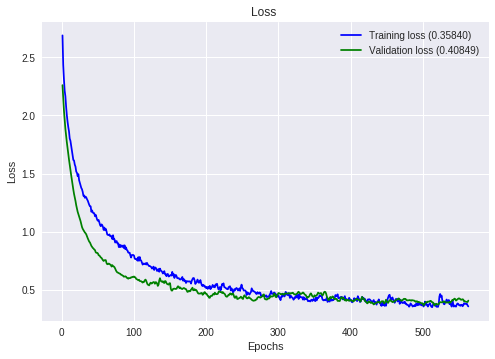

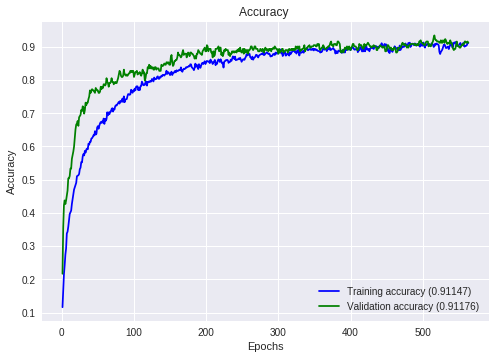

In [0]:
plot_history(history)

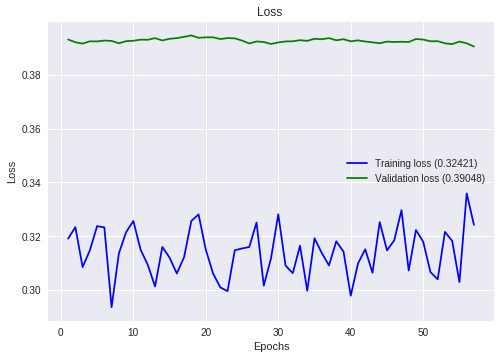

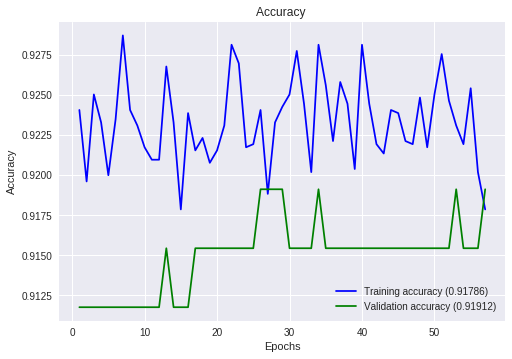

In [0]:
plot_history(history2)

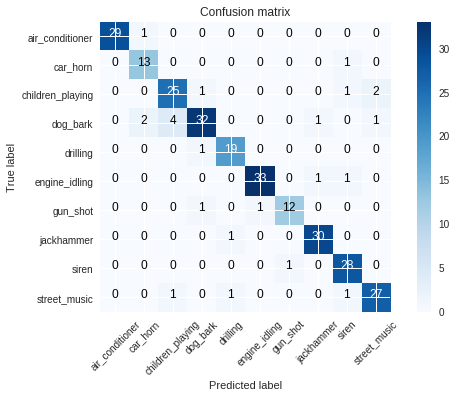

In [0]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_val_classes = np.argmax(y_val, axis=1) 
confusion_mtx = confusion_matrix(y_val_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Feature importance

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=2000, batch_size=1024, validation_data=(X_test, y_test), callbacks=cbs)    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

Train on 3640 samples, validate on 1794 samples
Epoch 1/2000
3640/3640 [==============================] - 1s 143us/step - loss: 100.6248 - acc: 0.1176 - val_loss: 93.8137 - val_acc: 0.1616
Epoch 2/2000
3640/3640 [==============================] - 0s 10us/step - loss: 90.9156 - acc: 0.1563 - val_loss: 84.5648 - val_acc: 0.1973
Epoch 3/2000
3640/3640 [==============================] - 0s 11us/step - loss: 81.8892 - acc: 0.1745 - val_loss: 76.0432 - val_acc: 0.2213
Epoch 4/2000
3640/3640 [==============================] - 0s 10us/step - loss: 73.5794 - acc: 0.2005 - val_loss: 68.2326 - val_acc: 0.2531
Epoch 5/2000
3640/3640 [==============================] - 0s 10us/step - loss: 66.0006 - acc: 0.2264 - val_loss: 61.1007 - val_acc: 0.2793
Epoch 6/2000
3640/3640 [==============================] - 0s 9us/step - loss: 59.0739 - acc: 0.2448 - val_loss: 54.6149 - val_acc: 0.3216
Epoch 7/2000
3640/3640 [==============================] - 0s 13us/step - loss: 52.7323 - acc: 0.2918 - val_loss: 48.7

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

Weight,Feature
0.2441 ± 0.0093,mfcc0
0.1351 ± 0.0052,mfcc3
0.1244 ± 0.0081,zcr
0.1104 ± 0.0054,mfcc5
0.1027 ± 0.0083,spec_contrast1
0.1018 ± 0.0040,spec_contrast2
0.0988 ± 0.0063,mfcc1
0.0902 ± 0.0070,spec_contrast0
0.0868 ± 0.0068,mfcc2
0.0858 ± 0.0031,mfcc7


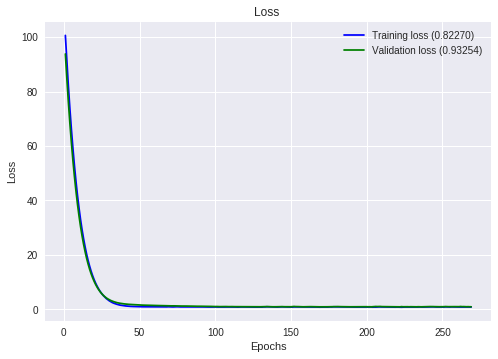

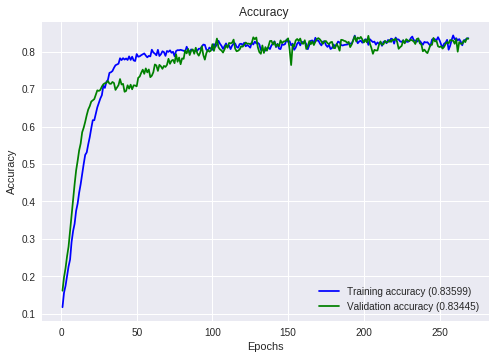

In [0]:
plot_history(hist)

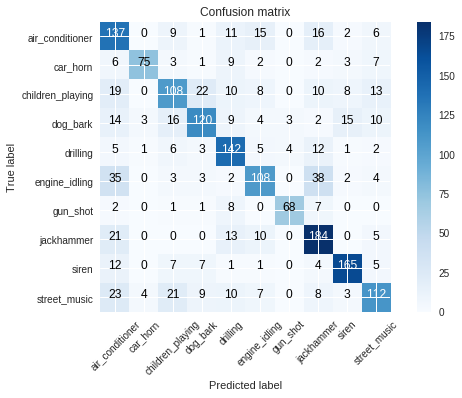

In [0]:
y_pred = my_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_test_classes = np.argmax(y_test, axis=1) 
confusion_mtx = confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Evaluate

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = encoder.inverse_transform(np.argmax(y_pred, axis=1))

In [0]:
np.array(ids).shape, y_pred_classes.shape

((3297,), (3297,))

In [0]:
res = pd.DataFrame({'ID': ids, 'Class': y_pred_classes})
res.to_csv(test_out_data_file, index=False)
res.head(10)

,Class,ID
0,car_horn,1002
1,children_playing,1005
2,children_playing,1009
3,dog_bark,1010
4,dog_bark,1011
5,drilling,1012
6,jackhammer,1013
7,engine_idling,1016
8,engine_idling,1019
9,engine_idling,102


# Neural networks using custom v2(3) + aug1

## Prepare data

In [0]:
# train_data_file augmented_train_data_file
data = skl.utils.shuffle(pd.read_csv(augmented_train_data_file), random_state=42)
data.head()

,filename,wn_coef,roll,stretching,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,chroma_stft9,chroma_stft10,chroma_stft11,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,label
144924,5414,0.005,100,1.0,-115.657742,73.220560,-76.647925,-31.889535,-10.899055,-27.931335,...,0.648305,0.625505,0.647618,-0.009050,-0.004545,-0.002798,0.033666,-0.002970,-0.007701,dog_bark
45537,2424,0.005,10,1.0,216.762680,49.187626,-22.181335,-9.410360,-16.538041,8.190257,...,0.800072,0.873133,0.903397,0.001183,0.003054,-0.000748,0.005915,0.001783,0.001694,siren
68974,3143,0.005,50,1.2,-117.136976,71.356428,-19.463747,18.309174,-19.778960,-1.620213,...,0.746581,0.644478,0.785490,0.018568,0.002647,0.067877,0.028402,0.001655,-0.004084,street_music
125755,4805,0.010,50,1.2,-192.873523,47.630516,8.053805,4.049595,11.106370,13.855496,...,0.743564,0.724730,0.712791,-0.009810,-0.002739,-0.109966,0.041153,0.019953,-0.012641,engine_idling
136933,5151,0.010,100,1.2,1.182846,10.191225,-42.524709,-2.153936,-14.510786,10.047924,...,0.803613,0.994671,0.848273,-0.001407,0.014257,0.000369,-0.018504,-0.000777,0.009774,drilling


In [0]:
# test_data_file
test_data = pd.read_csv(test_data_file)
test_data.head()

,filename,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,...,mel124,mel125,mel126,mel127,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5
0,1002,-54.163509,78.196477,-24.648497,19.057854,1.085420,21.774836,5.326390,7.400166,0.797973,...,8.096698e-03,4.066376e-02,1.545045e-02,2.309630e-04,-0.008010,0.011489,0.004514,0.048653,0.016759,0.002906
1,1005,-498.542471,109.428995,-44.941161,26.490302,-16.301730,22.205991,-2.689298,13.313584,0.534248,...,1.556226e-07,9.793334e-08,2.664464e-08,3.582307e-09,-0.020592,0.009674,-0.004869,0.082447,0.012947,-0.022081
2,1009,-197.268915,25.441026,-32.460610,27.992681,-8.737591,37.892281,0.816682,22.064938,-5.171717,...,6.079613e-04,3.662756e-04,7.256838e-05,3.900466e-06,-0.014660,0.008643,0.006326,0.003374,0.003270,0.004381
3,1010,-375.567498,110.323011,-35.257349,-29.015163,-3.364236,-2.352215,-12.537630,-11.761990,2.706602,...,3.197441e-04,1.646495e-04,2.757078e-05,2.090493e-06,-0.000280,0.011665,-0.038748,-0.015320,0.009604,0.002949
4,1011,-191.977751,121.961306,-11.721782,19.788359,7.778484,6.874192,-23.130696,4.172194,23.457142,...,2.924045e-04,1.726315e-04,8.078657e-05,6.776322e-05,0.025675,0.014862,-0.009255,-0.171520,0.013155,0.011339


In [0]:
data.shape, test_data.shape

((200345, 44), (3297, 168))

In [0]:
ids = test_data['filename']

In [0]:
data = data.drop(['filename', 'wn_coef', 'roll', 'stretching'], axis=1)
test_data = test_data.drop(['filename'], axis=1)
for i in range(128):
  test_data = test_data.drop([f'mel{i}'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



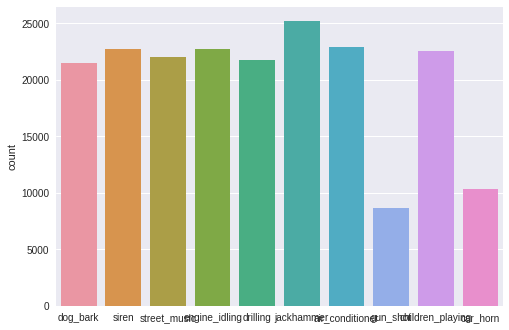

In [0]:
sns.countplot(np.array(genre_list))

In [0]:
X_data = np.append(np.array(data.iloc[:, :-1], dtype=float), np.array(test_data, dtype=float), axis=0)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(X_data)
X_train = X[:len(data)]
X_test = X[len(data):]

In [0]:
#for i in range(X.shape[1]):
  #plt.figure()
  #sns.distplot(X[:,i])
  #plt.title(data.columns[i])

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [0]:
X_train.shape, X_val.shape, y_val.shape, y_val.shape, X_test.shape

((160276, 39), (40069, 39), (40069, 10), (40069, 10), (3297, 39))

## Model

Conv > Normalization > Activation > Dropout > Pooling

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  
  model.add(layers.Dense(167, input_shape=(x_shape,), kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(167, kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(42, kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return model


In [0]:
cbs = [callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=50, mode='auto', restore_best_weights=True)]

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])

In [0]:
model.summary()

## Run

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=2048,
                    validation_data=(X_val, y_val),
                    callbacks=cbs)

In [0]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

history2 = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=cbs)

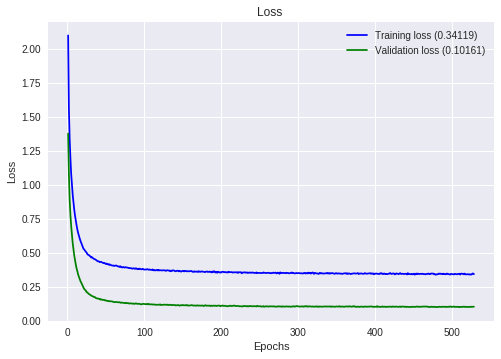

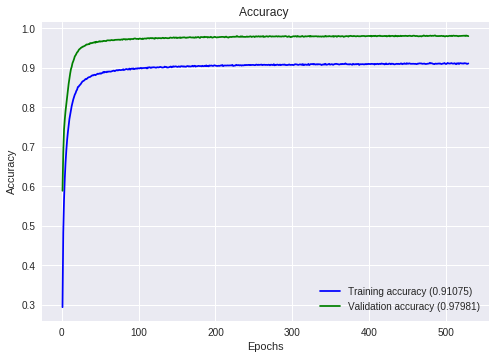

In [0]:
plot_history(history)

In [0]:
plot_history(history2)

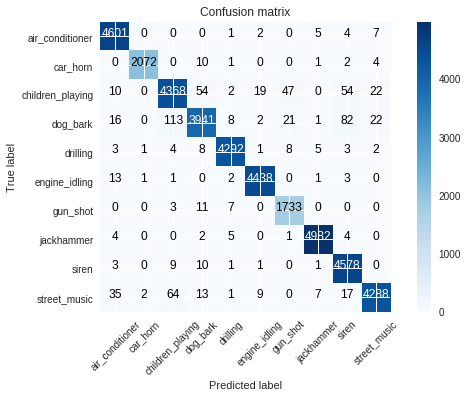

In [0]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_val_classes = np.argmax(y_val, axis=1) 
confusion_mtx = confusion_matrix(y_val_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Feature importance

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=2000, batch_size=2048, validation_data=(X_val, y_val), callbacks=cbs)    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

In [0]:
plot_history(hist)

In [0]:
y_pred = my_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_val_classes = np.argmax(y_val, axis=1) 
confusion_mtx = confusion_matrix(y_val_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Evaluate

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = encoder.inverse_transform(np.argmax(y_pred, axis=1))

In [0]:
np.array(ids).shape, y_pred_classes.shape

((3297,), (3297,))

In [0]:
res = pd.DataFrame({'ID': ids, 'Class': y_pred_classes})
res.to_csv('/content/drive/My Drive/contest_aug1_test_out.csv', index=False)
res.head(10)

,Class,ID
0,street_music,1002
1,dog_bark,1005
2,children_playing,1009
3,dog_bark,1010
4,dog_bark,1011
5,drilling,1012
6,jackhammer,1013
7,engine_idling,1016
8,air_conditioner,1019
9,drilling,102


# Neural networks using custom v2(3) + aug2

## Prepare data

In [0]:
# train_data_file augmented_train_data_file
data = skl.utils.shuffle(pd.read_csv(augmented_train_data_file), random_state=42)
data.head()

,filename,wn_coef,roll,stretching,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,chroma_stft9,chroma_stft10,chroma_stft11,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,label
144924,5414,0.005,100,1.0,-115.657742,73.220560,-76.647925,-31.889535,-10.899055,-27.931335,...,0.648305,0.625505,0.647618,-0.009050,-0.004545,-0.002798,0.033666,-0.002970,-0.007701,dog_bark
45537,2424,0.005,10,1.0,216.762680,49.187626,-22.181335,-9.410360,-16.538041,8.190257,...,0.800072,0.873133,0.903397,0.001183,0.003054,-0.000748,0.005915,0.001783,0.001694,siren
68974,3143,0.005,50,1.2,-117.136976,71.356428,-19.463747,18.309174,-19.778960,-1.620213,...,0.746581,0.644478,0.785490,0.018568,0.002647,0.067877,0.028402,0.001655,-0.004084,street_music
125755,4805,0.010,50,1.2,-192.873523,47.630516,8.053805,4.049595,11.106370,13.855496,...,0.743564,0.724730,0.712791,-0.009810,-0.002739,-0.109966,0.041153,0.019953,-0.012641,engine_idling
136933,5151,0.010,100,1.2,1.182846,10.191225,-42.524709,-2.153936,-14.510786,10.047924,...,0.803613,0.994671,0.848273,-0.001407,0.014257,0.000369,-0.018504,-0.000777,0.009774,drilling


In [0]:
# test_data_file
test_data = pd.read_csv(test_data_file)
test_data.head()

,filename,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,...,mel124,mel125,mel126,mel127,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5
0,1002,-54.163509,78.196477,-24.648497,19.057854,1.085420,21.774836,5.326390,7.400166,0.797973,...,8.096698e-03,4.066376e-02,1.545045e-02,2.309630e-04,-0.008010,0.011489,0.004514,0.048653,0.016759,0.002906
1,1005,-498.542471,109.428995,-44.941161,26.490302,-16.301730,22.205991,-2.689298,13.313584,0.534248,...,1.556226e-07,9.793334e-08,2.664464e-08,3.582307e-09,-0.020592,0.009674,-0.004869,0.082447,0.012947,-0.022081
2,1009,-197.268915,25.441026,-32.460610,27.992681,-8.737591,37.892281,0.816682,22.064938,-5.171717,...,6.079613e-04,3.662756e-04,7.256838e-05,3.900466e-06,-0.014660,0.008643,0.006326,0.003374,0.003270,0.004381
3,1010,-375.567498,110.323011,-35.257349,-29.015163,-3.364236,-2.352215,-12.537630,-11.761990,2.706602,...,3.197441e-04,1.646495e-04,2.757078e-05,2.090493e-06,-0.000280,0.011665,-0.038748,-0.015320,0.009604,0.002949
4,1011,-191.977751,121.961306,-11.721782,19.788359,7.778484,6.874192,-23.130696,4.172194,23.457142,...,2.924045e-04,1.726315e-04,8.078657e-05,6.776322e-05,0.025675,0.014862,-0.009255,-0.171520,0.013155,0.011339


In [0]:
data.shape, test_data.shape

((200345, 44), (3297, 168))

In [0]:
filenames = skl.utils.shuffle(np.unique(data['filename']), random_state=42)
filenames[:5]

array([2366, 2195, 5594, 1628, 5663])

In [0]:
data['filename'] = pd.Categorical(data['filename'], filenames)
data = data.sort_values('filename')
data.head()

,filename,wn_coef,roll,stretching,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,chroma_stft9,chroma_stft10,chroma_stft11,tonnetz0,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,label
43724,2366,0.007,10,0.8,-200.808946,73.564705,25.134607,7.737435,10.732779,5.560362,...,0.839904,0.768847,0.771618,0.013297,0.012646,0.006034,-0.014838,0.012990,-0.001693,air_conditioner
43741,2366,0.010,25,1.2,-186.740067,62.074205,25.919206,8.378705,9.133542,6.618035,...,0.810098,0.764392,0.802077,0.017512,0.000929,0.012215,-0.030400,0.009538,0.004947,air_conditioner
43736,2366,0.010,10,0.8,-186.703025,61.412773,26.288124,8.722906,8.661243,6.755487,...,0.789893,0.759763,0.788968,0.007584,0.010686,0.008128,-0.016627,0.010224,-0.002305,air_conditioner
43708,2366,0.000,50,1.2,-236.332957,108.697315,14.409042,7.057469,12.775994,3.032693,...,0.847526,0.791874,0.816025,0.009870,0.010786,0.034053,-0.029257,0.016975,-0.005563,air_conditioner
43702,2366,0.000,10,1.2,-235.959887,108.669916,14.468148,6.402052,12.428805,2.980086,...,0.779318,0.740183,0.760751,0.005796,0.002566,0.005260,-0.031299,0.008153,0.002365,air_conditioner


In [0]:
split_index = int(len(data) * 0.8) + 1
for i in range(split_index, len(data)):
  if data['filename'][split_index] != data['filename'][split_index - 1]:
    break
  split_index += 1

data['filename'][split_index], data['filename'][split_index - 1], split_index, split_index / len(data)

(5888, 5887, 160310, 0.8001697072549852)

In [0]:
ids = test_data['filename']

In [0]:
data = data.drop(['filename', 'wn_coef', 'roll', 'stretching'], axis=1)
test_data = test_data.drop(['filename'], axis=1)
for i in range(128):
  test_data = test_data.drop([f'mel{i}'], axis=1)

In [0]:
# Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = skl.preprocessing.LabelEncoder()
y = encoder.fit_transform(genre_list)
y = utils.to_categorical(y)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



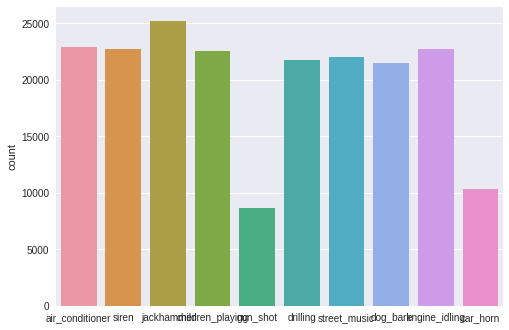

In [0]:
sns.countplot(np.array(genre_list))

In [0]:
X_data = np.append(np.array(data.iloc[:, :-1], dtype=float), np.array(test_data, dtype=float), axis=0)

In [0]:
scaler = skl.preprocessing.StandardScaler()
X = scaler.fit_transform(X_data)
X_data = X[:len(data)]
X_test = X[len(data):]

In [0]:
#for i in range(X.shape[1]):
  #plt.figure()
  #sns.distplot(X[:,i])
  #plt.title(data.columns[i])

In [0]:
X_train = X_data[:split_index]
X_val = X_data[split_index:]
y_train = y[:split_index]
y_val = y[split_index:]

In [0]:
X_train.shape, X_val.shape, y_val.shape, y_val.shape, X_test.shape

((160310, 39), (40035, 39), (40035, 10), (40035, 10), (3297, 39))

## Model

Conv > Normalization > Activation > Dropout > Pooling

In [0]:
def get_model(x_shape, y_shape):
  model = models.Sequential()
  
  model.add(layers.Dense(167, input_shape=(x_shape,), kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(167, kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(42, kernel_regularizer=regularizers.l2(0.0001)))
  model.add(layers.BatchNormalization())
  model.add(layers.Activation('relu'))
  model.add(layers.Dropout(0.5))
  
  model.add(layers.Dense(y_shape, activation='softmax'))
  
  model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.001), metrics=['accuracy'])
  return model


In [0]:
cbs = [callbacks.EarlyStopping(
    monitor='loss', min_delta=0, patience=50, mode='auto', restore_best_weights=True)]

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 167)               6680      
_________________________________________________________________
batch_normalization_46 (Batc (None, 167)               668       
_________________________________________________________________
activation_46 (Activation)   (None, 167)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 167)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 167)               28056     
_________________________________________________________________
batch_normalization_47 (Batc (None, 167)               668       
_________________________________________________________________
activation_47 (Activation)   (None, 167)               0         
__________

## Run

In [0]:
model = get_model(X_train.shape[1], y_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=2048,
                    validation_data=(X_val, y_val),
                    callbacks=cbs)

Train on 160310 samples, validate on 40035 samples
Epoch 1/2000
160310/160310 [==============================] - 5s 30us/step - loss: 2.0482 - acc: 0.3005 - val_loss: 1.3559 - val_acc: 0.5987
Epoch 2/2000
160310/160310 [==============================] - 1s 9us/step - loss: 1.5250 - acc: 0.4865 - val_loss: 1.0982 - val_acc: 0.6866
Epoch 3/2000
160310/160310 [==============================] - 1s 9us/step - loss: 1.3273 - acc: 0.5664 - val_loss: 0.9402 - val_acc: 0.7273
Epoch 4/2000
160310/160310 [==============================] - 1s 8us/step - loss: 1.1798 - acc: 0.6224 - val_loss: 0.8373 - val_acc: 0.7504
Epoch 5/2000
160310/160310 [==============================] - 1s 9us/step - loss: 1.0703 - acc: 0.6618 - val_loss: 0.7668 - val_acc: 0.7711
Epoch 6/2000
160310/160310 [==============================] - 1s 9us/step - loss: 0.9841 - acc: 0.6947 - val_loss: 0.6995 - val_acc: 0.7888
Epoch 7/2000
160310/160310 [==============================] - 1s 9us/step - loss: 0.9101 - acc: 0.7202 - val

In [0]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy'])

history2 = model.fit(X_train,
                    y_train,
                    epochs=2000,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=cbs)

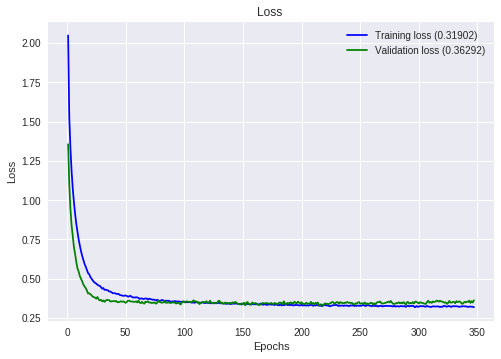

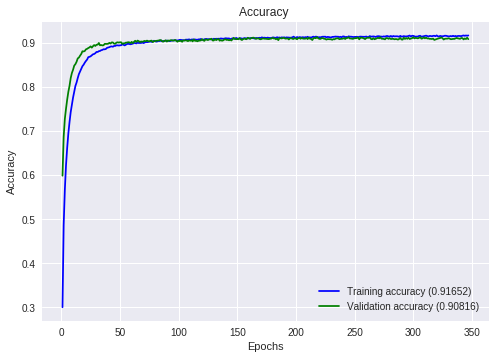

In [0]:
plot_history(history)

In [0]:
plot_history(history2)

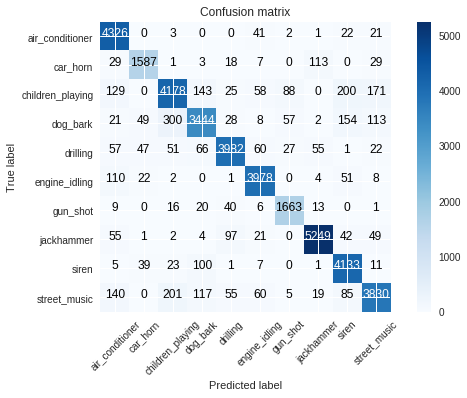

In [0]:
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_val_classes = np.argmax(y_val, axis=1) 
confusion_mtx = confusion_matrix(y_val_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Feature importance

In [0]:
my_model = KerasRegressor(build_fn=get_model,
  x_shape=X_train.shape[1], y_shape=y_train.shape[1],
  epochs=2000, batch_size=1024, validation_data=(X_test, y_test), callbacks=cbs)    
hist = my_model.fit(X_train, y_train)
perm = PermutationImportance(my_model, random_state=42).fit(X_train, y_train)

In [0]:
eli5.show_weights(perm, feature_names=data.columns[:-1].tolist(), top=None)

In [0]:
plot_history(hist)

In [0]:
y_pred = my_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_val_classes = np.argmax(y_val, axis=1) 
confusion_mtx = confusion_matrix(y_val_classes, y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=encoder.classes_)

## Evaluate

In [0]:
y_pred = model.predict(X_test)
y_pred_classes = encoder.inverse_transform(np.argmax(y_pred, axis=1))

In [0]:
np.array(ids).shape, y_pred_classes.shape

((3297,), (3297,))

In [0]:
res = pd.DataFrame({'ID': ids, 'Class': y_pred_classes})
res.to_csv('/content/drive/My Drive/contest_aug2_test_out.csv', index=False)
res.head(10)

,Class,ID
0,street_music,1002
1,children_playing,1005
2,street_music,1009
3,dog_bark,1010
4,dog_bark,1011
5,drilling,1012
6,jackhammer,1013
7,air_conditioner,1016
8,engine_idling,1019
9,drilling,102
